# Logistic Regression for Fraud Detection

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Model training
from sklearn.linear_model import LogisticRegression

# Model Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV


## Data read-in

In [2]:
# Train sets
x_train = pd.read_csv('./Datasets/x_train.csv')
y_train = pd.read_csv('./Datasets/y_train.csv')

# Validation sets
x_valid = pd.read_csv('./Datasets/x_valid.csv')
y_valid = pd.read_csv('./Datasets/y_valid.csv')

# Test sets
x_test = pd.read_csv('./Datasets/x_test.csv')
y_test = pd.read_csv('./Datasets/y_test.csv')


In [3]:
x_train.head()


,device_os_windows,income_0.9,customer_age_60,keep_alive_session,has_other_cards,housing_status_BE,device_os_other,customer_age_50,housing_status_BC,customer_age_20,phone_home_valid,payment_type_AC,housing_status_BB,employment_status_CC,credit_risk_score,proposed_credit_limit,date_of_birth_distinct_emails_4w,name_email_similarity,current_address_months_count,log_device_distinct_emails_8w
0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0.330769,0.005236,0.194444,0.247106,0.344059,0.693147
1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0.538462,0.162304,0.333333,0.087147,0.032178,0.405465
2,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0.519231,0.162304,0.527778,0.104738,0.212871,0.405465
3,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0.423077,0.005236,0.388889,0.197178,0.069307,0.405465
4,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0.359615,0.005236,0.138889,0.412427,0.146040,0.405465


In [4]:
y_train.head()


,fraud_bool
0,1
1,0
2,0
3,0
4,0


## Train Log Regression model on Training set

In [5]:
model = LogisticRegression()

# Fit the model to the training data
model.fit(x_train, y_train)


/Users/bumlife/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

## Plot ROC Curve to Optimize Threshold for F1-Score

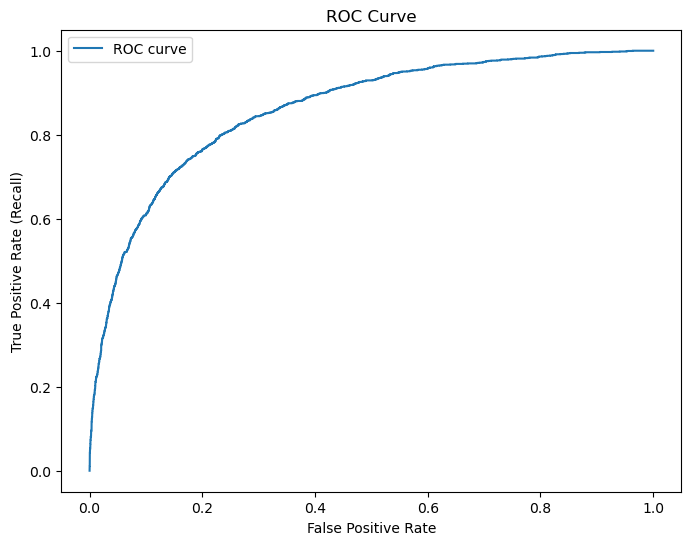

In [6]:
y_prob = model.predict_proba(x_valid)[:, 1]  

fpr, tpr, thresholds = roc_curve(y_valid, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [7]:
f1_scores = []
for threshold in thresholds:
    y_pred_threshold = (y_prob >= threshold).astype(int)
    f1_scores.append(f1_score(y_valid, y_pred_threshold))

optimal_threshold = thresholds[np.argmax(f1_scores)]
print("Optimal Threshold for F1-score:", optimal_threshold)

Optimal Threshold for F1-score: 0.2585014261782957


## Initial Evaluation on the Validation set

In [8]:
# Predict on the validation set
y_pred = (model.predict(x_valid) >= optimal_threshold).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred)

print("Validation Set Metrics Before Hyperparameter Tuning:")
print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}, ROC-AUC: {roc_auc:.2f}")


Validation Set Metrics Before Hyperparameter Tuning:
Accuracy: 0.85, Precision: 0.71, Recall: 0.44, F1-score: 0.54, ROC-AUC: 0.70


In [9]:
# Calculate the confusion matrix
confusion = confusion_matrix(y_valid, y_pred)

print("Confusion Matrix:")
print(confusion)


Confusion Matrix:
[[6324  293]
 [ 927  728]]


## Hyperparameter Tuning 

In [10]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10], # Regularization parameter
    'penalty': ['l1', 'l2'], # Type of regularization to apply
    'solver': ['liblinear', 'lbfgs', 'saga'] # Optimization algo used 
}

# 5 fold cross validation with recall as evaluation metric
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1')

# Tuning
grid_search.fit(x_train, y_train.values.ravel())

# Retrieving best parameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}


/Users/bumlife/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
25 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/bumlife/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/bumlife/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/bumlife/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    sol

## Cross-evaluation on the Validation set

In [11]:
# Create the best model with the best hyperparameters
best_model = LogisticRegression(**best_params)

# Fit the best model to the training data
best_model.fit(x_train, y_train.values.ravel())

# Predict on the validation set
y_valid_pred = (best_model.predict(x_valid) >= optimal_threshold).astype(int)

# Evaluate the best model on the validation set
accuracy_valid = accuracy_score(y_valid, y_valid_pred)
precision_valid = precision_score(y_valid, y_valid_pred)
recall_valid = recall_score(y_valid, y_valid_pred)
f1_valid = f1_score(y_valid, y_valid_pred)
roc_auc_valid = roc_auc_score(y_valid, y_valid_pred)

print("Validation Set Metrics After Hyperparameter Tuning:")
print(f"Accuracy: {accuracy_valid:.2f}, Precision: {precision_valid:.2f}, Recall: {recall_valid:.2f}, F1-score: {f1_valid:.2f}, ROC-AUC: {roc_auc_valid:.2f}")


Validation Set Metrics After Hyperparameter Tuning:
Accuracy: 0.85, Precision: 0.71, Recall: 0.44, F1-score: 0.54, ROC-AUC: 0.70


In [12]:
# Calculate the confusion matrix
confusion = confusion_matrix(y_valid, y_valid_pred)

print("Confusion Matrix:")
print(confusion)


Confusion Matrix:
[[6322  295]
 [ 926  729]]


## Evaluation on the Test set

In [13]:
# Fit model on test set
y_test_pred = (best_model.predict(x_test)>= optimal_threshold).astype(int)

accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)

print("Test Set Metrics:")
print(f"Accuracy: {accuracy_test:.2f}, Precision: {precision_test:.2f}, Recall: {recall_test:.2f}, F1-score: {f1_test:.2f}, ROC-AUC: {roc_auc_test:.2f}")


Test Set Metrics:
Accuracy: 0.86, Precision: 0.72, Recall: 0.46, F1-score: 0.56, ROC-AUC: 0.71


In [14]:
# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_test_pred)

print("Confusion Matrix:")
print(confusion)


Confusion Matrix:
[[6316  302]
 [ 896  758]]
